# Product Review Classification

## Business Understanding
Our company wants a tool that will automatically classify product reviews as _positive_ or _negative_ reviews, based on the features of the review.  This will help our Product team to perform more sophisticated analyses in the future to help ensure customer satisfaction.

## Data Understanding
We have a labeled collection of 20,000 product reviews, with an equal split of positive and negative reviews. The dataset contains the following features:

 - `ProductId` Unique identifier for the product
 - `UserId` Unqiue identifier for the user
 - `ProfileName` Profile name of the user
 - `HelpfulnessNumerator` Number of users who found the review helpful
 - `HelpfulnessDenominator` Number of users who indicated whether they found the review helpful or not
 - `Time` Timestamp for the review
 - `Summary` Brief summary of the review
 - `Text` Text of the review
 - `PositiveReview` 1 if this was labeled as a positive review, 0 if it was labeled as a negative review

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers

import time 

In [2]:
df = pd.read_csv("reviews.csv")
df.head(3)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,PositiveReview
0,B002QWHJOU,A37565LZHTG1VH,C. Maltese,1,1,1305331200,Awesome!,This is a great product. My 2 year old Golden ...,1
1,B000ESLJ6C,AMUAWXDJHE4D2,angieseashore,1,1,1320710400,Was there a recipe change?,I have been drinking Pero ever since I was a l...,0
2,B004IJJQK4,AMHHNAFJ9L958,A M,0,1,1321747200,These taste so bland.,"Look, each pack contains two servings of 120 c...",0


The data has already been cleaned, so there are no missing values

In [3]:
df.isna().sum()

ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Time                      0
Summary                   0
Text                      0
PositiveReview            0
dtype: int64

`PositiveReview` is the target, and all other columns are features

In [4]:
X = df.drop("PositiveReview", axis=1)
y = df["PositiveReview"]

## Data Preparation

First, split into train and test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape

(15000, 8)

Second, prepare for modeling. The following `Pipeline` prepares all data for modeling.  It one-hot encodes the `ProductId`, applies a tf-idf vectorizer to the `Summary` and `Text`, keeps the numeric columns as-is, and drops all other columns.

The following code may take up to 1 minute to run.

In [6]:
def drop_irrelevant_columns(X):
    return X.drop(["UserId", "ProfileName"], axis=1)

pipeline = Pipeline(steps=[
    ("drop_columns", FunctionTransformer(drop_irrelevant_columns)),
    ("transform_text_columns", ColumnTransformer(transformers=[
        ("ohe", OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False), ["ProductId"]),
        ("summary-tf-idf", TfidfVectorizer(max_features=1000), "Summary"),
        ("text-tf-idf", TfidfVectorizer(max_features=1000), "Text")
    ], remainder="passthrough"))
])

X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

X_train_transformed.shape

(15000, 11275)

In [17]:
X_train_transformed

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.3382496e+09],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 6.0000000e+00,
        7.0000000e+00, 1.3252896e+09],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.5000000e+01,
        2.5000000e+01, 1.2589344e+09],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.3463712e+09],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        1.0000000e+00, 1.3340160e+09],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.1000000e+01,
        1.4000000e+01, 1.2594528e+09]])

## Modeling

Fit a `RandomForestClassifier` with the best hyperparameters.  The following code may take up to 1 minute to run.

In [113]:
start_time = time.time()
rfc = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=30,
    min_samples_split=15,
    min_samples_leaf=1
)
rfc.fit(X_train_transformed, y_train)
rfc_time = time.time() - start_time
rfc_preds_train = rfc.predict(X_train_transformed)
rfc_preds_test = rfc.predict(X_test_transformed)
print(f"It took {rfc_time} to run")

It took 46.04483366012573 to run


## Model Evaluation

We are using _accuracy_ as our metric, which is the default metric in Scikit-Learn, so it is possible to just use the built-in `.score` method

In [8]:
print("Train accuracy:", rfc.score(X_train_transformed, y_train))
print("Test accuracy:", rfc.score(X_test_transformed, y_test))

Train accuracy: 0.9826666666666667
Test accuracy: 0.913


In [9]:
print("Train confusion matrix:")
print(confusion_matrix(y_train, rfc.predict(X_train_transformed)))
print("Test confusion matrix:")
print(confusion_matrix(y_test, rfc.predict(X_test_transformed)))

Train confusion matrix:
[[7312  177]
 [  83 7428]]
Test confusion matrix:
[[2293  218]
 [ 217 2272]]


## Business Interpretation

The tuned Random Forest Classifier model appears to be somewhat overfit on the training data, but nevertheless achieves 91% accuracy on the test data.  Of the 9% of mislabeled comments, about half are false positives and half are false negatives.

Because this is a balanced dataset, 91% accuracy is a substantial improvement over a 50% baseline.  This model is ready for production use for decision support.

In [14]:
df.columns

Index(['ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'PositiveReview'],
      dtype='object')

In [21]:
ss = StandardScaler()

X_train_transformed_scaled = ss.fit_transform(X_train_transformed)
X_test_transformed_scaled = ss.transform(X_test_transformed)

In [26]:
X_train_transformed_scaled.shape

(15000, 11275)

In [34]:
# base model
model = Sequential()
model.add(Dense(units = 64, activation = 'tanh', input_shape = (11275, )))
model.add(Dense(units = 64, activation = 'tanh'))
model.add(Dense(units = 64, activation = 'tanh'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train_transformed_scaled, y_train, validation_split = 0.1, batch_size = 50, epochs = 5)

Train on 13500 samples, validate on 1500 samples
Epoch 1/5
13500/13500 [==============================] - 3s 202us/sample - loss: 0.3583 - accuracy: 0.8439 - val_loss: 0.2279 - val_accuracy: 0.9120
Epoch 2/5
13500/13500 [==============================] - 2s 162us/sample - loss: 0.0869 - accuracy: 0.9696 - val_loss: 0.2840 - val_accuracy: 0.9027
Epoch 3/5
13500/13500 [==============================] - 2s 159us/sample - loss: 0.0165 - accuracy: 0.9949 - val_loss: 0.3528 - val_accuracy: 0.9007
Epoch 4/5
13500/13500 [==============================] - 2s 162us/sample - loss: 0.0064 - accuracy: 0.9981 - val_loss: 0.3885 - val_accuracy: 0.8947
Epoch 5/5
13500/13500 [==============================] - 2s 163us/sample - loss: 0.0037 - accuracy: 0.9991 - val_loss: 0.3660 - val_accuracy: 0.9060


In [33]:
# changing activation functions
model = Sequential()
model.add(Dense(units = 64, activation = 'relu', input_shape = (11275, )))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train_transformed_scaled, y_train, validation_split = 0.1, batch_size = 50, epochs = 5)

Train on 13500 samples, validate on 1500 samples
Epoch 1/5
13500/13500 [==============================] - 3s 200us/sample - loss: 0.3179 - accuracy: 0.8624 - val_loss: 0.2011 - val_accuracy: 0.9187
Epoch 2/5
13500/13500 [==============================] - 2s 162us/sample - loss: 0.0333 - accuracy: 0.9891 - val_loss: 0.2591 - val_accuracy: 0.9120
Epoch 3/5
13500/13500 [==============================] - 2s 162us/sample - loss: 0.0059 - accuracy: 0.9979 - val_loss: 0.2970 - val_accuracy: 0.9113
Epoch 4/5
13500/13500 [==============================] - 2s 161us/sample - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.3216 - val_accuracy: 0.9147
Epoch 5/5
13500/13500 [==============================] - 2s 167us/sample - loss: 5.7422e-04 - accuracy: 0.9999 - val_loss: 0.3306 - val_accuracy: 0.9133


In [35]:
# changing units
model = Sequential()
model.add(Dense(units = 64, activation = 'relu', input_shape = (11275, )))
model.add(Dense(units = 32, activation = 'tanh'))
model.add(Dense(units = 96, activation = 'tanh'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train_transformed_scaled, y_train, validation_split = 0.1, batch_size = 50, epochs = 5)

Train on 13500 samples, validate on 1500 samples
Epoch 1/5
13500/13500 [==============================] - 3s 202us/sample - loss: 0.3011 - accuracy: 0.8695 - val_loss: 0.2069 - val_accuracy: 0.9147
Epoch 2/5
13500/13500 [==============================] - 2s 161us/sample - loss: 0.0373 - accuracy: 0.9881 - val_loss: 0.2407 - val_accuracy: 0.9200
Epoch 3/5
13500/13500 [==============================] - 2s 162us/sample - loss: 0.0091 - accuracy: 0.9973 - val_loss: 0.2720 - val_accuracy: 0.9173
Epoch 4/5
13500/13500 [==============================] - 2s 162us/sample - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.3049 - val_accuracy: 0.9153
Epoch 5/5
13500/13500 [==============================] - 2s 161us/sample - loss: 9.4831e-04 - accuracy: 0.9997 - val_loss: 0.3260 - val_accuracy: 0.9207


In [43]:
# changing units again
# added l2 regularization
model = Sequential()
model.add(Dense(units = 64, activation = 'relu', input_shape = (11275, )))
model.add(Dense(units = 128, activation = 'tanh', kernel_regularizer = regularizers.l2(0.005)))
model.add(Dense(units = 128, activation = 'tanh', kernel_regularizer = regularizers.l2(0.005)))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train_transformed_scaled, y_train, validation_split = 0.1, batch_size = 50, epochs = 5)

Train on 13500 samples, validate on 1500 samples
Epoch 1/5
13500/13500 [==============================] - 3s 215us/sample - loss: 0.8066 - accuracy: 0.8722 - val_loss: 0.4032 - val_accuracy: 0.9220
Epoch 2/5
13500/13500 [==============================] - 2s 167us/sample - loss: 0.1305 - accuracy: 0.9909 - val_loss: 0.2804 - val_accuracy: 0.9120
Epoch 3/5
13500/13500 [==============================] - 2s 166us/sample - loss: 0.0342 - accuracy: 0.9983 - val_loss: 0.2677 - val_accuracy: 0.9113
Epoch 4/5
13500/13500 [==============================] - 2s 167us/sample - loss: 0.0146 - accuracy: 0.9996 - val_loss: 0.2569 - val_accuracy: 0.9153
Epoch 5/5
13500/13500 [==============================] - 2s 168us/sample - loss: 0.0097 - accuracy: 0.9998 - val_loss: 0.2652 - val_accuracy: 0.9100


In [45]:
# changing epoch size
model = Sequential()
model.add(Dense(units = 64, activation = 'tanh', input_shape = (11275, )))
model.add(Dense(units = 128, activation = 'tanh', kernel_regularizer = regularizers.l2(0.005)))
model.add(Dense(units = 128, activation = 'tanh', kernel_regularizer = regularizers.l2(0.005)))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train_transformed_scaled, y_train, validation_split = 0.1, batch_size = 50, epochs = 50)

Train on 13500 samples, validate on 1500 samples
Epoch 1/50
13500/13500 [==============================] - 3s 211us/sample - loss: 0.7681 - accuracy: 0.8655 - val_loss: 0.3735 - val_accuracy: 0.9087
Epoch 2/50
13500/13500 [==============================] - 2s 173us/sample - loss: 0.1105 - accuracy: 0.9858 - val_loss: 0.2637 - val_accuracy: 0.9100
Epoch 3/50
13500/13500 [==============================] - 2s 171us/sample - loss: 0.0299 - accuracy: 0.9959 - val_loss: 0.2529 - val_accuracy: 0.9193
Epoch 4/50
13500/13500 [==============================] - 2s 167us/sample - loss: 0.0147 - accuracy: 0.9987 - val_loss: 0.2714 - val_accuracy: 0.9153
Epoch 5/50
13500/13500 [==============================] - 2s 170us/sample - loss: 0.0102 - accuracy: 0.9998 - val_loss: 0.2707 - val_accuracy: 0.9160
Epoch 6/50
13500/13500 [==============================] - 2s 172us/sample - loss: 0.0085 - accuracy: 0.9999 - val_loss: 0.2749 - val_accuracy: 0.9140
Epoch 7/50
13500/13500 [===========================

In [48]:
# changing loss function
model = Sequential()
model.add(Dense(units = 64, activation = 'tanh', input_shape = (11275, )))
model.add(Dense(units = 128, activation = 'tanh', kernel_regularizer = regularizers.l2(0.005)))
model.add(Dense(units = 128, activation = 'tanh', kernel_regularizer = regularizers.l2(0.005)))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'poisson', metrics = ['accuracy'])
model.fit(X_train_transformed_scaled, y_train, validation_split = 0.1, batch_size = 50, epochs = 10)

Train on 13500 samples, validate on 1500 samples
Epoch 1/10
13500/13500 [==============================] - 3s 213us/sample - loss: 0.9882 - accuracy: 0.8656 - val_loss: 0.6621 - val_accuracy: 0.9087
Epoch 2/10
13500/13500 [==============================] - 2s 167us/sample - loss: 0.5514 - accuracy: 0.9799 - val_loss: 0.6237 - val_accuracy: 0.9060
Epoch 3/10
13500/13500 [==============================] - 2s 167us/sample - loss: 0.5184 - accuracy: 0.9920 - val_loss: 0.6279 - val_accuracy: 0.9173
Epoch 4/10
13500/13500 [==============================] - 2s 168us/sample - loss: 0.5113 - accuracy: 0.9961 - val_loss: 0.6387 - val_accuracy: 0.9153
Epoch 5/10
13500/13500 [==============================] - 2s 171us/sample - loss: 0.5085 - accuracy: 0.9984 - val_loss: 0.6378 - val_accuracy: 0.9180
Epoch 6/10
13500/13500 [==============================] - 2s 172us/sample - loss: 0.5072 - accuracy: 0.9990 - val_loss: 0.6416 - val_accuracy: 0.9140
Epoch 7/10
13500/13500 [===========================

In [49]:
# changing optimizer
model = Sequential()
model.add(Dense(units = 64, activation = 'tanh', input_shape = (11275, )))
model.add(Dense(units = 128, activation = 'tanh', kernel_regularizer = regularizers.l2(0.005)))
model.add(Dense(units = 128, activation = 'tanh', kernel_regularizer = regularizers.l2(0.005)))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train_transformed_scaled, y_train, validation_split = 0.1, batch_size = 50, epochs = 10)

Train on 13500 samples, validate on 1500 samples
Epoch 1/10
13500/13500 [==============================] - 3s 200us/sample - loss: 1.6385 - accuracy: 0.6771 - val_loss: 1.4641 - val_accuracy: 0.8053
Epoch 2/10
13500/13500 [==============================] - 2s 159us/sample - loss: 1.2695 - accuracy: 0.8992 - val_loss: 1.2762 - val_accuracy: 0.8633
Epoch 3/10
13500/13500 [==============================] - 2s 163us/sample - loss: 1.0359 - accuracy: 0.9793 - val_loss: 1.2174 - val_accuracy: 0.8753
Epoch 4/10
13500/13500 [==============================] - 2s 163us/sample - loss: 0.9299 - accuracy: 0.9956 - val_loss: 1.1768 - val_accuracy: 0.8813
Epoch 5/10
13500/13500 [==============================] - 2s 161us/sample - loss: 0.8673 - accuracy: 0.9984 - val_loss: 1.1416 - val_accuracy: 0.8773
Epoch 6/10
13500/13500 [==============================] - 2s 157us/sample - loss: 0.8169 - accuracy: 0.9993 - val_loss: 1.1067 - val_accuracy: 0.8800
Epoch 7/10
13500/13500 [===========================

In [57]:
# changing optimizer
# might be the best
model = Sequential()
model.add(Dense(units = 64, activation = 'tanh', input_shape = (11275, )))
model.add(Dense(units = 128, activation = 'tanh', kernel_regularizer = regularizers.l2(0.005)))
model.add(Dense(units = 128, activation = 'tanh', kernel_regularizer = regularizers.l2(0.005)))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'RMSprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train_transformed_scaled, y_train, validation_split = 0.1, batch_size = 50, epochs = 5)

Train on 13500 samples, validate on 1500 samples
Epoch 1/5
13500/13500 [==============================] - 4s 333us/sample - loss: 0.6786 - accuracy: 0.8787 - val_loss: 0.2764 - val_accuracy: 0.9280
Epoch 2/5
13500/13500 [==============================] - 3s 254us/sample - loss: 0.1279 - accuracy: 0.9689 - val_loss: 0.1984 - val_accuracy: 0.9293
Epoch 3/5
13500/13500 [==============================] - 3s 258us/sample - loss: 0.0588 - accuracy: 0.9857 - val_loss: 0.2354 - val_accuracy: 0.9193
Epoch 4/5
13500/13500 [==============================] - 4s 279us/sample - loss: 0.0328 - accuracy: 0.9924 - val_loss: 0.2911 - val_accuracy: 0.9167
Epoch 5/5
13500/13500 [==============================] - 4s 271us/sample - loss: 0.0230 - accuracy: 0.9946 - val_loss: 0.2520 - val_accuracy: 0.9173


In [52]:
# changing optimizer
model = Sequential()
model.add(Dense(units = 64, activation = 'tanh', input_shape = (11275, )))
model.add(Dense(units = 128, activation = 'tanh', kernel_regularizer = regularizers.l2(0.005)))
model.add(Dense(units = 128, activation = 'tanh', kernel_regularizer = regularizers.l2(0.005)))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'Adadelta', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train_transformed_scaled, y_train, validation_split = 0.1, batch_size = 50, epochs = 5)

Train on 13500 samples, validate on 1500 samples
Epoch 1/5
13500/13500 [==============================] - 3s 223us/sample - loss: 1.8006 - accuracy: 0.5021 - val_loss: 1.7867 - val_accuracy: 0.5100
Epoch 2/5
13500/13500 [==============================] - 3s 186us/sample - loss: 1.7926 - accuracy: 0.5085 - val_loss: 1.7795 - val_accuracy: 0.5153
Epoch 3/5
13500/13500 [==============================] - 3s 188us/sample - loss: 1.7852 - accuracy: 0.5151 - val_loss: 1.7726 - val_accuracy: 0.5213
Epoch 4/5
13500/13500 [==============================] - 2s 181us/sample - loss: 1.7781 - accuracy: 0.5206 - val_loss: 1.7660 - val_accuracy: 0.5287
Epoch 5/5
13500/13500 [==============================] - 2s 183us/sample - loss: 1.7712 - accuracy: 0.5263 - val_loss: 1.7596 - val_accuracy: 0.5347


In [56]:
# changing optimizer
model = Sequential()
model.add(Dense(units = 64, activation = 'tanh', input_shape = (11275, )))
model.add(Dense(units = 128, activation = 'tanh', kernel_regularizer = regularizers.l2(0.005)))
model.add(Dense(units = 128, activation = 'tanh', kernel_regularizer = regularizers.l2(0.005)))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'Ftrl', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train_transformed_scaled, y_train, validation_split = 0.1, batch_size = 50, epochs = 5)

Train on 13500 samples, validate on 1500 samples
Epoch 1/5
13500/13500 [==============================] - 3s 233us/sample - loss: 0.6973 - accuracy: 0.4947 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
13500/13500 [==============================] - 3s 188us/sample - loss: 0.6931 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
13500/13500 [==============================] - 3s 192us/sample - loss: 0.6931 - accuracy: 0.4996 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
13500/13500 [==============================] - 3s 193us/sample - loss: 0.6931 - accuracy: 0.5008 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
13500/13500 [==============================] - 3s 186us/sample - loss: 0.6931 - accuracy: 0.5008 - val_loss: 0.6931 - val_accuracy: 0.5000


In [61]:
# changing regularization strength
model = Sequential()
model.add(Dense(units = 64, activation = 'tanh', input_shape = (11275, )))
model.add(Dense(units = 128, activation = 'tanh', kernel_regularizer = regularizers.l2(0.1)))
model.add(Dense(units = 128, activation = 'tanh', kernel_regularizer = regularizers.l2(0.1)))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'RMSprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train_transformed_scaled, y_train, validation_split = 0.1, batch_size = 50, epochs = 5)

Train on 13500 samples, validate on 1500 samples
Epoch 1/5
13500/13500 [==============================] - 4s 308us/sample - loss: 3.3002 - accuracy: 0.8934 - val_loss: 0.2391 - val_accuracy: 0.9327
Epoch 2/5
13500/13500 [==============================] - 3s 257us/sample - loss: 0.1431 - accuracy: 0.9692 - val_loss: 0.2157 - val_accuracy: 0.9353
Epoch 3/5
13500/13500 [==============================] - 3s 256us/sample - loss: 0.0939 - accuracy: 0.9822 - val_loss: 0.2168 - val_accuracy: 0.9360
Epoch 4/5
13500/13500 [==============================] - 3s 250us/sample - loss: 0.0667 - accuracy: 0.9890 - val_loss: 0.2316 - val_accuracy: 0.9280
Epoch 5/5
13500/13500 [==============================] - 3s 252us/sample - loss: 0.0516 - accuracy: 0.9929 - val_loss: 0.2292 - val_accuracy: 0.9267


In [112]:
# changing regularization strength
# our best model, the one we will choose
start_time = time.time()
model = Sequential()
model.add(Dense(units = 64, activation = 'tanh', input_shape = (11275, )))
model.add(Dense(units = 32, activation = 'tanh', kernel_regularizer = regularizers.l2(0.5)))
model.add(Dense(units = 32, activation = 'tanh', kernel_regularizer = regularizers.l2(0.5)))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'RMSprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train_transformed_scaled, y_train, validation_split = 0.1, batch_size = 50, epochs = 5)
nn_time = time.time() - start_time
y_hat_train = model.predict_classes(X_train_transformed_scaled)
y_hat_test = model.predict_classes(X_test_transformed_scaled)

print(f"It took {nn_time} to run")

Train on 13500 samples, validate on 1500 samples
Epoch 1/5
13500/13500 [==============================] - 4s 305us/sample - loss: 9.3329 - accuracy: 0.8790 - val_loss: 0.4554 - val_accuracy: 0.9373
Epoch 2/5
13500/13500 [==============================] - 3s 245us/sample - loss: 0.3149 - accuracy: 0.9564 - val_loss: 0.3091 - val_accuracy: 0.9333
Epoch 3/5
13500/13500 [==============================] - 3s 245us/sample - loss: 0.2190 - accuracy: 0.9724 - val_loss: 0.2681 - val_accuracy: 0.9407
Epoch 4/5
13500/13500 [==============================] - 3s 246us/sample - loss: 0.1708 - accuracy: 0.9810 - val_loss: 0.2595 - val_accuracy: 0.9347
Epoch 5/5
13500/13500 [==============================] - 3s 245us/sample - loss: 0.1383 - accuracy: 0.9864 - val_loss: 0.2469 - val_accuracy: 0.9347
It took 17.538179397583008 to run


In [66]:
# accuracy on the training data
accuracy_score(y_train, y_hat_train)

0.9872666666666666

In [69]:
confusion_matrix(y_train, y_hat_train)

array([[7383,  106],
       [  85, 7426]], dtype=int64)

In [67]:
# accuracy on the test data
accuracy_score(y_test, y_hat_test)

0.9304

In [68]:
confusion_matrix(y_test, y_hat_test)

array([[2326,  185],
       [ 163, 2326]], dtype=int64)

In [100]:
def plot_results(model):
    fig, (ax1,ax2) = plt.subplots(1,2)

    ax1.plot(model.history.epoch, model.history.history['loss'], label='loss')
    ax1.plot(model.history.epoch, model.history.history['val_loss'], label='val_loss')
    ax1.set_ylim(0.1,0.4)
    ax1.legend()
    
    ax2.plot(model.history.epoch, model.history.history['accuracy'], label='accuracy')
    ax2.plot(model.history.epoch, model.history.history['val_accuracy'], label='val_accuracy')

    ax2.legend()

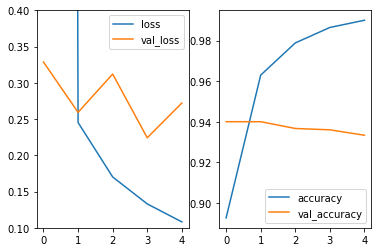

In [101]:
plot_results(model)

In [114]:
print("Neural Network Model Evaluation\n")
print("Model runtime:", nn_time)
print("\nTrain accuracy:", accuracy_score(y_train, y_hat_train))
print("Train confusion matrix:")
print(confusion_matrix(y_train, y_hat_train, normalize = 'true'))
print("\nTest accuracy:", accuracy_score(y_test, y_hat_test))
print("Test confusion matrix:")
print(confusion_matrix(y_test, y_hat_test, normalize = 'true'))

Neural Network Model Evaluation

Model runtime: 17.538179397583008

Train accuracy: 0.9864
Train confusion matrix:
[[0.98758179 0.01241821]
 [0.01477833 0.98522167]]

Test accuracy: 0.9366
Test confusion matrix:
[[0.9398646  0.0601354 ]
 [0.06669345 0.93330655]]


In [115]:
print("Random Forest Classifier Evaluation\n")
print("Model runtime:", rfc_time)
print("\nTrain accuracy:", rfc.score(X_train_transformed, y_train))
print("Train confusion matrix:")
print(confusion_matrix(y_train, rfc.predict(X_train_transformed), normalize = 'true'))
print("\nTest accuracy:", rfc.score(X_test_transformed, y_test))
print("Test confusion matrix:")
print(confusion_matrix(y_test, rfc.predict(X_test_transformed), normalize = 'true'))

Random Forest Classifier Evaluation

Model runtime: 46.04483366012573

Train accuracy: 0.9826666666666667
Train confusion matrix:
[[0.97636534 0.02363466]
 [0.01105046 0.98894954]]

Test accuracy: 0.913
Test confusion matrix:
[[0.913182   0.086818  ]
 [0.08718361 0.91281639]]


In [138]:
import seaborn as sns
sns.set(style = 'whitegrid')
dv = pd.DataFrame(data = [[nn_time, accuracy_score(y_train, y_hat_train), accuracy_score(y_test, y_hat_test), 'NN'], [rfc_time, rfc.score(X_train_transformed, y_train), rfc.score(X_test_transformed, y_test), 'RFC']], columns = ['Runtime', 'Train Data Accuracy', 'Test Data Accuracy', 'Model'])

[Text(0, 0.5, ''), Text(0.5, 0, '')]

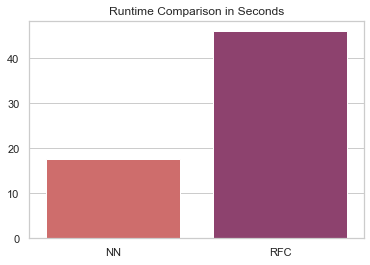

In [149]:
ax = sns.barplot(x = 'Model', y = 'Runtime', data = dv, palette = 'flare')
ax.set_title('Runtime Comparison in Seconds')
ax.set(ylabel = '', xlabel = '')

[(0.98, 0.989), Text(0, 0.5, ''), Text(0.5, 0, '')]

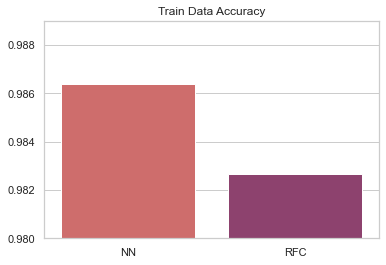

In [148]:
ax = sns.barplot(x = 'Model', y = 'Train Data Accuracy', data = dv, palette = 'flare')
ax.set_title('Train Data Accuracy')
ax.set(ylim = (0.98,0.989), ylabel = '', xlabel = '')

[(0.9, 0.95), Text(0, 0.5, ''), Text(0.5, 0, '')]

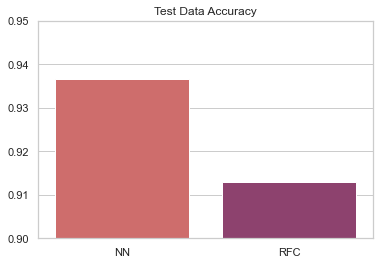

In [153]:
ax = sns.barplot(x = 'Model', y = 'Test Data Accuracy', data = dv, palette = 'flare')
ax.set_title('Test Data Accuracy')
ax.set(ylim = (0.90,0.95), ylabel = '', xlabel = '')

# Our neural network model is better.

The Northwind Trading Company should swap to our new neural network model for several reasons.  In regards to our model performance on our training data, it performs better, though it is by such a small margin that it should not be really taken into account.  However, our neural network has a much much lower computational complexity, and can be initialized, fitted, and predict 170%!!! faster than the random forest classifier.  When working with other, larger datasets this could be the difference between waiting an hour to get your numbers and waiting an entire afternoon.  Not only that, the neural network has a better accuracy score when it comes to datasets that are outside of our train data.